In [ ]:
import numpy as np
import pandas as pd
from astropy.io import fits
from eval_utils import label_field, stellar_metrics
from scipy.stats import norm

import pickle
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

hdul = fits.open('data/dataset3_subset2.fits')
dataset = hdul[1].data
hdul.close()

test_ind = np.load('data/3_2_test.npy')

label_f = label_field(dataset, regr=False, new=True)

classes = label_f.classes
indices = label_f.ord_to_idx(classes)

y_true = indices[test_ind]
with open('predictions.pkl', 'rb') as f:
    ultimate_dict = pickle.load(f)

print(f'Model list available: {list(ultimate_dict.keys())}')

def stratified_indices(y, n_reps=1000, rng=None):
    """Return a list of length `n_reps`, each an array of bootstrap indices
        drawn with replacement *within* every class of `y`."""
    rng = np.random.default_rng(rng)
    class_to_idx = {c: np.where(y == c)[0] for c in np.unique(y)}
    reps = []
    for _ in range(n_reps):
        sample = np.concatenate([
            rng.choice(idxs, size=len(idxs), replace=True)
            for idxs in class_to_idx.values()
        ])
        reps.append(sample)
    return reps

idx_boot = stratified_indices(y_true, rng=1337)

def jackknife_indices(n_samples):
    """
    Generator that yields the index array for each leave-one-out replicate.

    """
    full = np.arange(n_samples)
    for i in range(n_samples):
        # everything except position i
        yield np.concatenate((full[:i], full[i+1:]))

def bca_ci(boot_vals, jack_vals, true_val, alpha=0.95):
    """
    Bias-Corrected & Accelerated (BCa) bootstrap CI.

    Parameters
    ----------
    boot_vals : 1-D array
        Bootstrap distribution of a statistic (length B).
    jack_vals : 1-D array
        Jack-knife distribution of the same statistic (length N).
    alpha : float
        Confidence level (0.95 → 95 % CI).

    Returns
    -------
    (lower, upper) tuple
        End-points of the two-sided BCa confidence interval.
    """
    boot_vals = np.asarray(boot_vals)
    jack_vals = np.asarray(jack_vals)

    B = boot_vals.size           # # bootstrap resamples
    z0 = norm.ppf(               # bias-correction
        (boot_vals < true_val).mean()
    )

    # acceleration from jack-knife influence values
    jack_mean = jack_vals.mean()
    numer = np.sum((jack_mean - jack_vals)**3)
    denom = 6.0 * (np.sum((jack_mean - jack_vals)**2) ** 1.5)
    a = numer / denom

    # helper: transform nominal ↦ adjusted percentiles
    def _pct(q):
        z = norm.ppf(q)
        adj = norm.cdf(z0 + (z0 + z) / (1 - a * (z0 + z)))
        return 100 * adj  # convert to percentile (0–100)

    q_lo, q_hi = (1 - alpha) / 2, 1 - (1 - alpha) / 2
    lo = np.percentile(boot_vals, _pct(q_lo))
    hi = np.percentile(boot_vals, _pct(q_hi))
    return lo, hi

def bootstrap_pvalue(gaps, delta_hat, two_sided=True, add_one=True):
    """
    Bootstrap p-value for H0: Δ = 0 using the paired bootstrap distribution.

    Parameters
    ----------
    gaps      : 1-D array of bootstrap gaps (A − B)  – shape (B,)
    delta_hat : Observed gap on the full sample.
    two_sided : If True, return a two-sided p-value.  If False, upper-tail.
    add_one   : Whether to apply the common (+1)/(B+1) finite-sample correction.

    Returns
    -------
    p         : float   – bootstrap p-value.
    """
    B = len(gaps)
    # centre the distribution so the null is at 0
    centred = gaps - delta_hat

    if two_sided:
        extreme = np.abs(centred) >= abs(delta_hat)
    else:  # upper-tail test (Δ > 0)
        extreme = centred >= delta_hat

    count = extreme.sum()
    if add_one:          # prevents a p-value of exactly 0
        count += 1
        B += 1
    return count / B

Model list available: ['conv1d_best', 'conv1d_half_ord', 'conv1d_no_ord', 'resnet50_1d', 'conv1d_old', 'convkan', 'convtran']


In [ ]:
def two_models(model1, model2):
    preds_a = ultimate_dict[model1]['preds']
    preds_b = ultimate_dict[model2]['preds']

    def paired_bootstrap_gap(actuals, preds_a, preds_b, indices):
        """Return bootstrap vector of metric differences (A - B)."""
        def one_rep(idx):
            yt_t, yp_t_a, y_pt_b = actuals[idx], preds_a[idx], preds_b[idx]
            sm_a = stellar_metrics(label_f, yp_t_a, yt_t, True, False)
            sm_b = stellar_metrics(label_f, y_pt_b, yt_t, True, False)

            return (sm_a.f1_macro()-sm_b.f1_macro(),
                    sm_a.mae()-sm_b.mae(),
                    sm_a.two_stage_qwk("q")[0]-sm_b.two_stage_qwk("q")[0],
                    sm_a.two_stage_qwk("q")[1]-sm_b.two_stage_qwk("q")[1])
        return np.vstack([one_rep(idx) for idx in indices])
    
    true_gap = paired_bootstrap_gap(y_true, preds_a, preds_b, (np.arange(len(test_ind)),))[0]

    print(f'F1 Macro Δ: {true_gap[0]:.2%}')
    print(f'Mean Absolute Error Δ: {true_gap[1]:.4f}')
    print(f'Q-Weighted Kappa Δ: {true_gap[2]:.2%}, {true_gap[3]:.2%}')

    gaps_full = paired_bootstrap_gap(y_true, preds_a, preds_b, idx_boot)

    gaps_jack = paired_bootstrap_gap(y_true, preds_a, preds_b, jackknife_indices(len(y_true)))


    ci = [bca_ci(gaps_full[:,i], gaps_jack[:,i], true_gap[i]) for i in range(4)]
    p_two_sided = [bootstrap_pvalue(gaps_full[:,i], true_gap[i]) for i in range(4)]

    print('\n Confidence intervals for Δ:')
    for (lo, hi), p in zip(ci,p_two_sided):
        print(f"\t {lo:.4f}  –  {hi:.4f} (p = {p:.4%})")
    print('--------------------------------\n\n')

In [ ]:
two_models('conv1d_best','resnet50_1d')

F1 Macro Δ: 4.28%
Mean Absolute Error Δ: -0.0035
Q-Weighted Kappa Δ: 0.07%, -8.72%

 Confidence intervals for Δ:
	 0.0132  –  0.0804 (p = 1.3986%)
	 -0.0205  –  0.0131 (p = 72.3277%)
	 -0.0091  –  0.0174 (p = 89.5105%)
	 -0.1767  –  -0.0054 (p = 4.2957%)
--------------------------------




In [ ]:
two_models('conv1d_best','conv1d_no_ord')

F1 Macro Δ: 1.30%
Mean Absolute Error Δ: -0.0015
Q-Weighted Kappa Δ: 0.46%, -2.36%

 Confidence intervals for Δ:
	 -0.0112  –  0.0444 (p = 36.3636%)
	 -0.0170  –  0.0158 (p = 86.7133%)
	 -0.0022  –  0.0153 (p = 27.5724%)
	 -0.1059  –  0.0757 (p = 58.8412%)
--------------------------------




In [ ]:
from scipy.stats import mode

def ensemble_models(models, method):
    preds = np.empty((1295,len(models),39))
    for i,model in enumerate(models):
            preds[:,i,:] = ultimate_dict[model]['scores']
    if method == 'mean':
        return preds.sum(axis=1).argmax(axis=-1)
    elif method == 'vote':
        return mode(preds.argmax(axis=-1),axis=-1)[0]

hey = ensemble_models(['conv1d_best', 'conv1d_half_ord', 'conv1d_no_ord', 'resnet50_1d'], 'vote')

In [ ]:
hey

array([31, 10, 22, ..., 15, 14, 26])

In [ ]:
def metrics_for_model(actuals, preds, idx_boot):
        def one_rep(idx):
            yt_t, yp_t = actuals[idx], preds[idx]
            sm = stellar_metrics(label_f, yp_t, yt_t, True, False)
    
            return (sm.f1_macro(),
                    sm.mae(),
                    sm.two_stage_qwk("q")[0],
                    sm.two_stage_qwk("q")[1])
        return np.vstack([one_rep(idx) for idx in idx_boot])

In [ ]:
from scipy.stats import mode

def ensemble_models(models, method):
    preds = np.empty((1295,len(models),39))
    for i,model in enumerate(models):
            preds[:,i,:] = ultimate_dict[model]['scores']
    if method == 'mean':
        return preds.sum(axis=1).argmax(axis=-1)
    elif method == 'vote':
        return mode(preds.argmax(axis=-1),axis=-1)[0]

hey = ensemble_models(['conv1d_best', 'conv1d_half_ord', 'conv1d_no_ord', 'resnet50_1d'], 'vote')

In [ ]:
true_val = metrics_for_model(y_true, hey, (np.arange(len(test_ind)),))[0]
    
print(f'F1 Macro: {true_val[0]:.2%}')
print(f'Mean Absolute Error: {true_val[1]:.4f}')
print(f'Q-Weighted Kappa: {true_val[2]:.2%}, {true_val[3]:.2%}')

F1 Macro: 64.23%
Mean Absolute Error: 0.1946
Q-Weighted Kappa: 96.60%, 61.78%


In [ ]:
from scipy.stats import mode

def ensemble_models(models, method):
    preds = np.empty((1295,len(models),39))
    for i,model in enumerate(models):
            preds[:,i,:] = ultimate_dict[model]['scores']
    if method == 'mean':
        return preds.sum(axis=1).argmax(axis=-1)
    elif method == 'vote':
        return mode(preds.argmax(axis=-1),axis=-1)[0]

hey = ensemble_models(['conv1d_best', 'conv1d_half_ord', 'conv1d_no_ord', 'resnet50_1d'], 'mean')

In [ ]:
true_val = metrics_for_model(y_true, hey, (np.arange(len(test_ind)),))[0]
    
print(f'F1 Macro: {true_val[0]:.2%}')
print(f'Mean Absolute Error: {true_val[1]:.4f}')
print(f'Q-Weighted Kappa: {true_val[2]:.2%}, {true_val[3]:.2%}')

F1 Macro: 66.87%
Mean Absolute Error: 0.1714
Q-Weighted Kappa: 97.65%, 68.38%


In [ ]:
from scipy.stats import mode

def ensemble_models(models, method):
    preds = np.empty((1295,len(models),39))
    for i,model in enumerate(models):
            preds[:,i,:] = ultimate_dict[model]['scores']
    if method == 'mean':
        return preds.sum(axis=1).argmax(axis=-1)
    elif method == 'vote':
        return mode(preds.argmax(axis=-1),axis=-1)[0]

hey = ensemble_models(['conv1d_best', 'resnet50_1d'], 'mean')

In [ ]:
true_val = metrics_for_model(y_true, hey, (np.arange(len(test_ind)),))[0]
    
print(f'F1 Macro: {true_val[0]:.2%}')
print(f'Mean Absolute Error: {true_val[1]:.4f}')
print(f'Q-Weighted Kappa: {true_val[2]:.2%}, {true_val[3]:.2%}')

F1 Macro: 67.67%
Mean Absolute Error: 0.1676
Q-Weighted Kappa: 97.79%, 72.06%


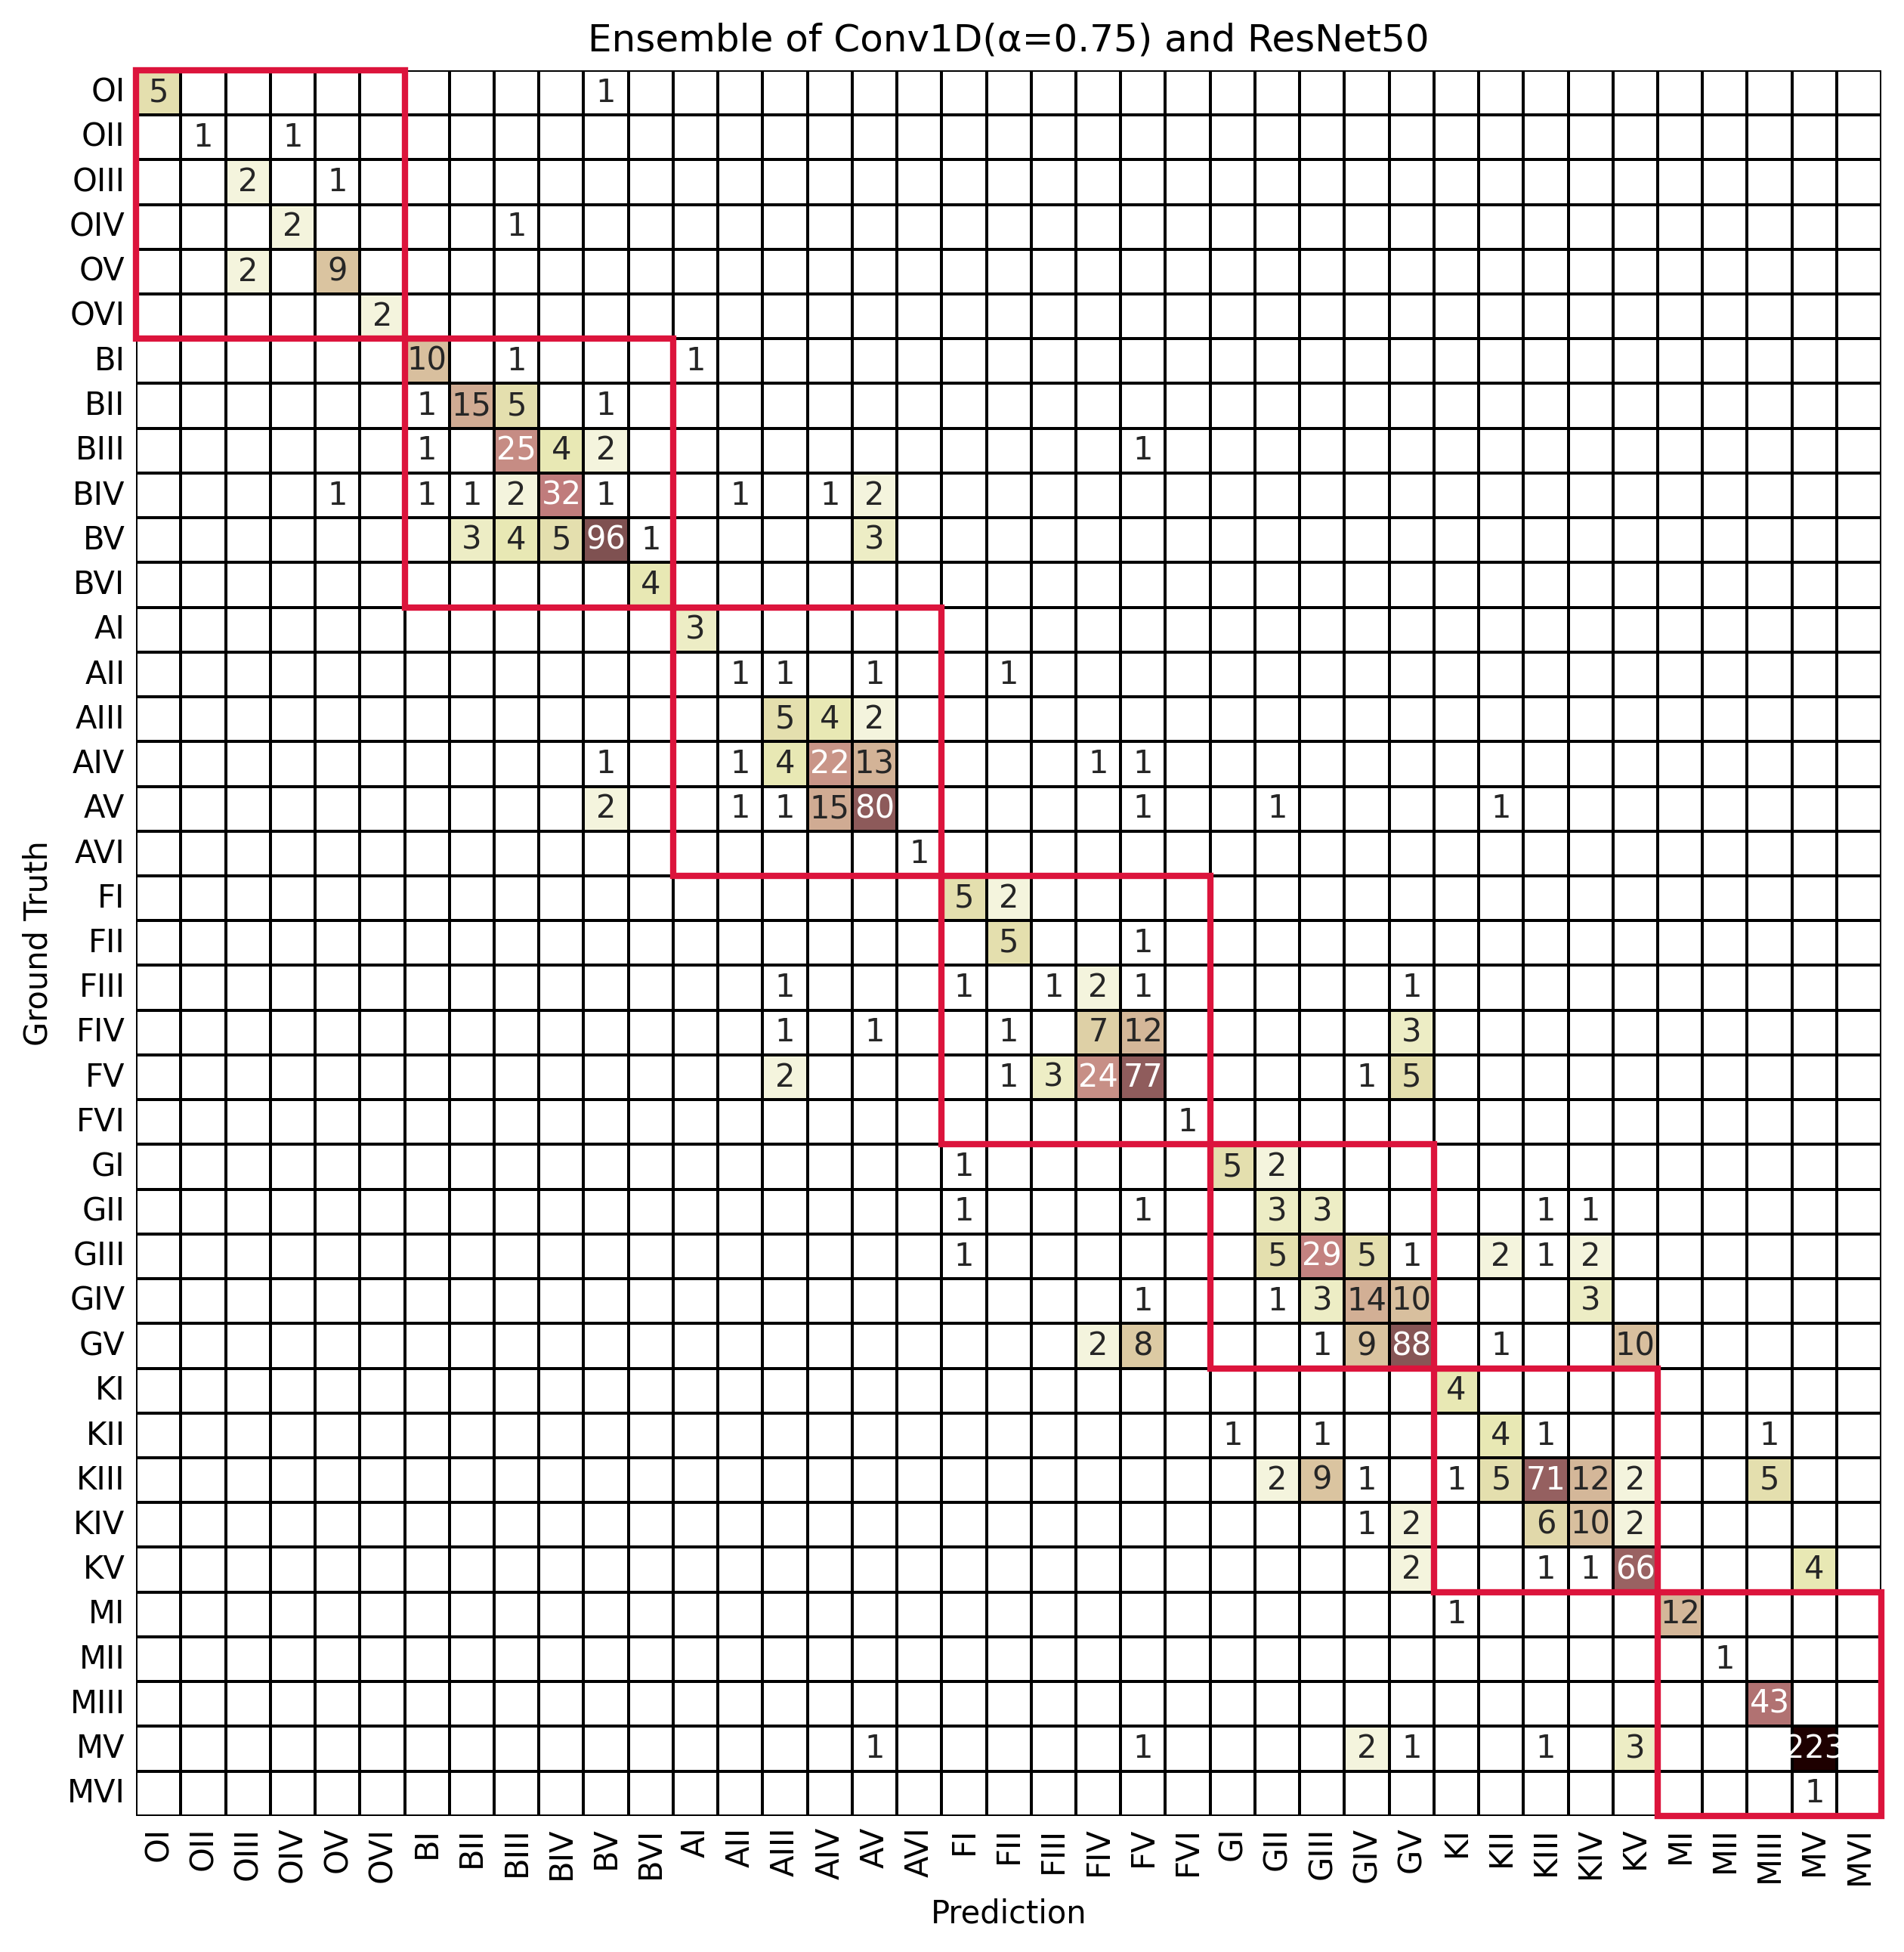

In [ ]:
sm = stellar_metrics(label_f, hey, y_true, idx=True, regr=False)

sm.draw_cm('Ensemble of Conv1D(α=0.75) and ResNet50', 300, False)

In [ ]:
sm.report('', False)
sm.report('temp', False)
sm.report('lum', False)

              precision    recall  f1-score   support

          OI     1.0000    0.8333    0.9091         6
         OII     1.0000    0.5000    0.6667         2
        OIII     0.5000    0.6667    0.5714         3
         OIV     0.6667    0.6667    0.6667         3
          OV     0.8182    0.8182    0.8182        11
         OVI     1.0000    1.0000    1.0000         2
          BI     0.7692    0.8333    0.8000        12
         BII     0.7895    0.6818    0.7317        22
        BIII     0.6579    0.7576    0.7042        33
         BIV     0.7805    0.7619    0.7711        42
          BV     0.9231    0.8571    0.8889       112
         BVI     0.8000    1.0000    0.8889         4
          AI     0.7500    1.0000    0.8571         3
         AII     0.2500    0.2500    0.2500         4
        AIII     0.3333    0.4545    0.3846        11
         AIV     0.5238    0.5116    0.5176        43
          AV     0.7767    0.7843    0.7805       102
         AVI     1.0000    

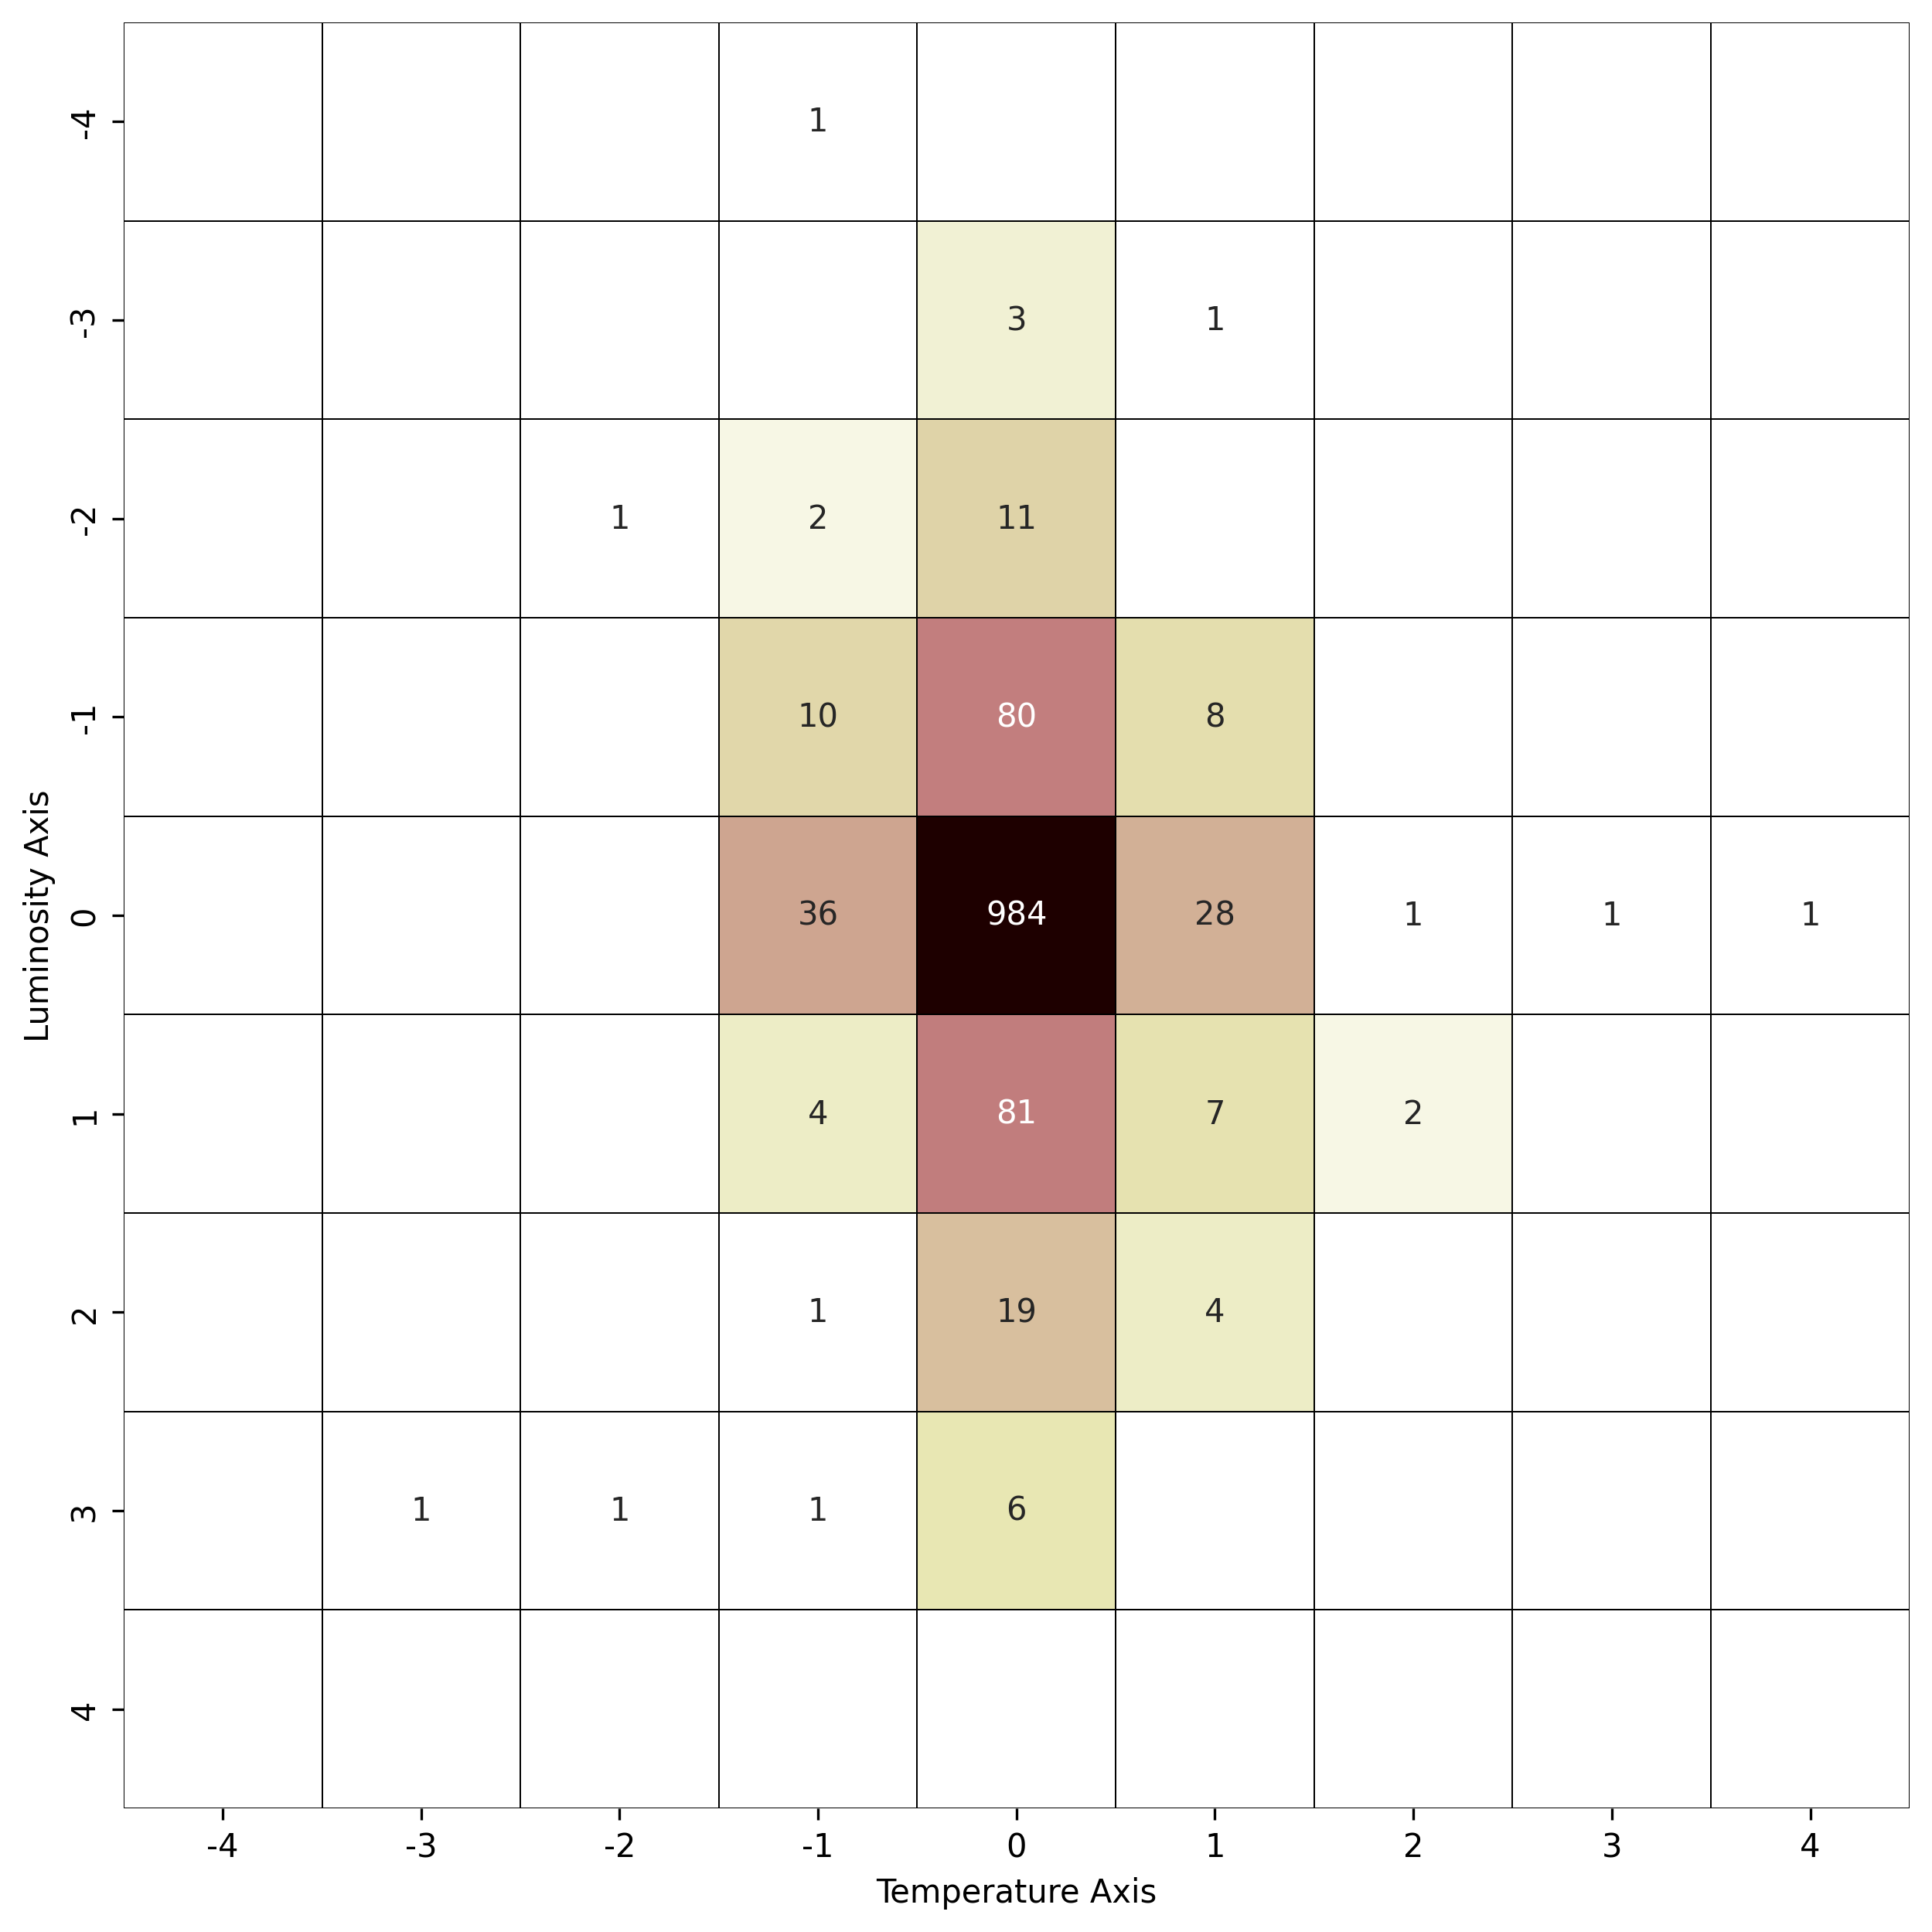

In [ ]:
sm.draw_ord_cm('',300)

In [ ]:
from scipy.stats import mode

def ensemble_models(models, method):
    preds = np.empty((1295,len(models),39))
    for i,model in enumerate(models):
            preds[:,i,:] = ultimate_dict[model]['scores']
    if method == 'mean':
        return preds.sum(axis=1).argmax(axis=-1)
    elif method == 'vote':
        return mode(preds.argmax(axis=-1),axis=-1)[0]

hey = ensemble_models(['conv1d_best', 'resnet50_1d'], 'mean')

In [ ]:
ultimate_dict.update({'ensemble_best':{'preds':hey,'scores':None}})

In [ ]:
def ensemble_models(models, method):
    preds = np.empty((1295,len(models),39))
    for i,model in enumerate(models):
            preds[:,i,:] = ultimate_dict[model]['scores']
    if method == 'mean':
        return preds.sum(axis=1).argmax(axis=-1)
    elif method == 'vote':
        return mode(preds.argmax(axis=-1),axis=-1)[0]

hey = ensemble_models(['conv1d_no_ord', 'resnet50_1d'], 'mean')

true_val = metrics_for_model(y_true, hey, (np.arange(len(test_ind)),))[0]
    
print(f'F1 Macro: {true_val[0]:.2%}')
print(f'Mean Absolute Error: {true_val[1]:.4f}')
print(f'Q-Weighted Kappa: {true_val[2]:.2%}, {true_val[3]:.2%}')

F1 Macro: 64.45%
Mean Absolute Error: 0.1757
Q-Weighted Kappa: 97.96%, 70.79%


In [ ]:
ultimate_dict.update({'ensemble_no_ord+resnet':{'preds':hey,'scores':None}})

In [ ]:
hey = ensemble_models(['conv1d_best', 'conv1d_half_ord'], 'mean')

true_val = metrics_for_model(y_true, hey, (np.arange(len(test_ind)),))[0]
    
print(f'F1 Macro: {true_val[0]:.2%}')
print(f'Mean Absolute Error: {true_val[1]:.4f}')
print(f'Q-Weighted Kappa: {true_val[2]:.2%}, {true_val[3]:.2%}')

F1 Macro: 63.54%
Mean Absolute Error: 0.1950
Q-Weighted Kappa: 97.06%, 62.05%


In [ ]:
ultimate_dict.update({'ensemble_best+half':{'preds':hey,'scores':None}})

In [ ]:
for key in ultimate_dict.keys():
    one_model(key)

Performance metrics and CI for conv1d_best
F1 Macro: 62.80%
Mean Absolute Error: 0.1942
Q-Weighted Kappa: 97.30%, 60.28%

 Confidence intervals:
	 0.5855  –  0.6699
	 0.1757  –  0.2139
	 0.9638  –  0.9795
	 0.5017  –  0.6841
--------------------------------


Performance metrics and CI for conv1d_half_ord
F1 Macro: 60.91%
Mean Absolute Error: 0.2170
Q-Weighted Kappa: 96.66%, 52.63%

 Confidence intervals:
	 0.5682  –  0.6503
	 0.1988  –  0.2386
	 0.9567  –  0.9748
	 0.4225  –  0.6004
--------------------------------


Performance metrics and CI for conv1d_no_ord
F1 Macro: 61.49%
Mean Absolute Error: 0.1958
Q-Weighted Kappa: 96.84%, 62.64%

 Confidence intervals:
	 0.5779  –  0.6580
	 0.1784  –  0.2160
	 0.9557  –  0.9768
	 0.5172  –  0.7071
--------------------------------


Performance metrics and CI for resnet50_1d
F1 Macro: 58.52%
Mean Absolute Error: 0.1977
Q-Weighted Kappa: 97.22%, 68.99%

 Confidence intervals:
	 0.5457  –  0.6231
	 0.1807  –  0.2179
	 0.9546  –  0.9818
	 0.5996 

In [ ]:
two_models('ensemble_best','resnet50_1d')

F1 Macro Δ: 9.15%
Mean Absolute Error Δ: -0.0301
Q-Weighted Kappa Δ: 0.57%, 3.06%

 Confidence intervals for Δ:
	 0.0682  –  0.1227 (p = 0.0999%)
	 -0.0432  –  -0.0173 (p = 0.0999%)
	 -0.0022  –  0.0225 (p = 33.7662%)
	 -0.0281  –  0.0868 (p = 30.0699%)
--------------------------------




In [ ]:
two_models('conv1d_best','conv1d_old')

F1 Macro Δ: 3.08%
Mean Absolute Error Δ: -0.0301
Q-Weighted Kappa Δ: 0.93%, -0.05%

 Confidence intervals for Δ:
	 -0.0038  –  0.0630 (p = 8.5914%)
	 -0.0494  –  -0.0122 (p = 0.0999%)
	 -0.0002  –  0.0260 (p = 13.6863%)
	 -0.0819  –  0.1098 (p = 99.0010%)
--------------------------------




In [ ]:
two_models('ensemble_best','conv1d_best')

F1 Macro Δ: 4.87%
Mean Absolute Error Δ: -0.0266
Q-Weighted Kappa Δ: 0.50%, 11.78%

Confidence intervals for Δ:
	 0.0297  –  0.0724 (p = 0.0999%)
	 -0.0407  –  -0.0158 (p = 0.0999%)
	 -0.0006  –  0.0115 (p = 10.9890%)
	 0.0606  –  0.1923 (p = 0.0999%)
--------------------------------




In [ ]:
two_models('conv1d_best','resnet50_1d')

F1 Macro Δ: 4.28%
Mean Absolute Error Δ: -0.0035
Q-Weighted Kappa Δ: 0.07%, -8.72%

Confidence intervals for Δ:
	 0.0132  –  0.0804 (p = 1.3986%)
	 -0.0205  –  0.0131 (p = 72.3277%)
	 -0.0091  –  0.0174 (p = 89.5105%)
	 -0.1767  –  -0.0054 (p = 4.2957%)
--------------------------------


